<a href="https://colab.research.google.com/github/WXXXQXXXCXX/smile/blob/vgg_model_1/smile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install keras_vggface

In [ ]:
!pip install keras_applications

In [ ]:
! pip install memory_profiler

In [1]:
import keras
from collections import defaultdict
from glob import glob
from random import choice, sample
from keras.preprocessing import image
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, LeakyReLU
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from memory_profiler import memory_usage

In [2]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
# keras.utils.layer_utils

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download recognizing-faces-in-the-wild

In [ ]:
! unzip train-faces

In [3]:
train_file_path = "train_relationships.csv"
val_famillies = "F09"
all_images = glob("*/*/*.jpg")
train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]
train_person_to_images_map = defaultdict(list)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]

for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

In [4]:
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

In [ ]:
# hyperparameters
EPOCH = 50
BATCHSIZE = 16

In [5]:
def read_img(path):
    img = image.load_img(path, target_size=(197, 197))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self,list_tuples, person_to_images_map, batch_size=16):
    self.list_tuples=list_tuples
    self.person_to_images_map=person_to_images_map
    self.batch_size=batch_size
    self.ppl=list(person_to_images_map.keys())

  def __len__(self):
    return int(np.floor(len(self.list_tuples) / self.batch_size))

  def __getitem__(self,index):
        'Generate one batch of data'
        batch_tuples = sample(self.list_tuples, self.batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < self.batch_size:
            p1 = choice(self.ppl)
            p2 = choice(self.ppl)

            if p1 != p2 and (p1, p2) not in self.list_tuples and (p2, p1) not in self.list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(self.person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(self.person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(self.person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        return [X1, X2], np.array(labels)

In [ ]:
"""
result=model.fit(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=92, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)
"""
def genOnetime(list_tuples, person_to_images_map, epochs=EPOCH, batch_size=16):
    ppl = list(person_to_images_map.keys())
    resultData1 = []
    resultData2 = []
    resultLabels = []
    for epoch in range(epochs):
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        resultData1.extend(X1)
        resultData2.extend(X2)
        resultLabels.extend(labels)
    resultData1 = np.array(resultData1)
    resultData2 = np.array(resultData2)
    resultLabels = np.array(resultLabels)
    return [resultData1,resultData2], resultLabels

In [7]:

def baseline_model(learning_rate=0.001, beta1=0.9, beta2=0.99):
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers:
        x.trainable = False

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x = Concatenate(axis=-1)([x4, x3])

    x = Dense(48, activation='relu')(x)
    #x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.01)(x)
    x = Dense(16, activation='relu')(x)
    #x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)
    adam=Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2)
    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=adam)

    model.summary()

    return model

In [8]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import Callback
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.24
config.gpu_options.visible_device_list = "0"
K.set_session(tf.compat.v1.Session(config=config))
class ClearSessionCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Memory usage after: {memory_usage()}MB')
        gc.collect()
        k.clear_session()
        print(f'Memory usage after clean up: {memory_usage()}MB')

In [9]:
file_path = "vgg_face.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=10, verbose=1)
clear_session=ClearSessionCallback()
earlyStopping=EarlyStopping(monitor="val_loss",mode="min",patience=25)

callbacks_list = [checkpoint, reduce_on_plateau, clear_session, earlyStopping]

In [ ]:
trdata, trtarget = genOnetime(train, train_person_to_images_map, epochs=EPOCH , batch_size=BATCHSIZE)
valdata, valtarget = genOnetime(val, val_person_to_images_map, epochs=EPOCH, batch_size=BATCHSIZE)
result=model.fit(x=trdata, y=trtarget, use_multiprocessing=True,
                    validation_data=(valdata, valtarget), epochs=EPOCH, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

In [10]:
train_gen=DataGenerator(train,train_person_to_images_map,16)
val_gen=DataGenerator(val,val_person_to_images_map,16)
r=-2*np.random.rand()-2
lr=pow(10,r)
print(lr,r)
model=baseline_model(0.0001)
result=model.fit(train_gen, use_multiprocessing=True,
          validation_data=val_gen, epochs=100, verbose=1,
          workers = 4, callbacks=callbacks_list, steps_per_epoch=180, validation_steps=80)

0.0021926798181286784 -2.659024780712772
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 197, 197, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 197, 197, 3  0           []                               
                                )]                                                                
                                                                                                  
 vggface_resnet50 (Functional)  (None, None, None,   23561152    ['input_1[0][0]',                
                                2048)                

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Memory usage after: [3204.109375]MB
Memory usage after clean up: [3204.234375]MB
180/180 [==============================] - 78s 370ms/step - loss: 4.9404 - acc: 0.5740 - val_loss: 2.8401 - val_acc: 0.5508 - lr: 1.0000e-04
Epoch 2/100
180/180 [==============================] - ETA: 0s - loss: 2.3209 - acc: 0.5885
Epoch 00002: val_acc improved from 0.55078 to 0.57187, saving model to vgg_face.h5
Memory usage after: [3237.37890625]MB
Memory usage after clean up: [3237.3359375]MB
180/180 [==============================] - 69s 371ms/step - loss: 2.3209 - acc: 0.5885 - val_loss: 1.9031 - val_acc: 0.5719 - lr: 1.0000e-04
Epoch 3/100
180/180 [==============================] - ETA: 0s - loss: 1.5101 - acc: 0.6101
Epoch 00003: val_acc improved from 0.57187 to 0.57500, saving model to vgg_face.h5
Memory usage after: [3237.41015625]MB
Memory usage after clean up: [3237.34765625]MB
180/180 [==============================] - 69s 373ms/step - loss: 1.5101 - acc: 0.6101 - val_loss: 1.4325 - val_acc: 0

In [11]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'vgg_face.h5(2)')

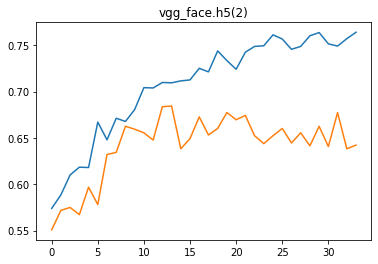

In [14]:
fig,ax=plt.subplots(1,1)
acc=result.history['acc']
val_acc=result.history['val_acc']
ax.plot(acc,label="train")
ax.plot(val_acc,label="test")
ax.set_title("vgg_face.h5(2)")
    

In [ ]:
fig,ax=plt.subplots(10,1)
for i in range(10):
    r=-3*np.random.rand()-1
    lr=pow(10,r)
    print(lr,r)
    model=baseline_model(learning_rate=lr)
    result=model.fit(train_gen, use_multiprocessing=True,
                    validation_data=val_gen, epochs=100, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=80)
    acc=result.history['accuracy']
    val_acc=result.history['val_acc']
    ax[i].plot(acc,label="train")
    ax[i].plot(val_acc,label="test")
    ax[i].set_title("learning rate="+str(lr))
    